In [60]:
import pandas as pd


# Corona Cases in Germany

What is the real number of infected peoply by the corona virus. What we learn in the news is just the number of positively tested people. Unfortunately, it is technically not possible to test everybody with possible corona virus symptoms. For example we learned that on the 18th of March we had 12327 known cases in Germany. An extremely important question is "How many unknown cases do we have?".

This is what this page is about. I try to estimate this number or better to calculate some possible boundaries for this number.

I started doing this project for myself. I didn't intend to publish it. Everyday the new data on the corona virus cases rains down on me by radio and TV. Day by day and in many cases only comparisons with the previous day. So I started collecting the data on a day to day basis.

But I am sure that I made you curious. You want to know now this "dark" number, the number of total cases, known plus unknown? What we hear about the severity of the disease, i.e. the death rate is also just a calculation on the known cases. So we have the division of the number of people who died due to the virus and the number of the known cases. The death rate given and based on known cases varies between 2.5 % and 5 %. The higher the number of unknown cases is the smaller the real death rate will be. I assumed that the "real" death rate might be 0.7, like a seasonal flu. Be aware: This is just an assumption, not covered by any scientific data, but anyway quite likely. I further assume that the avarage duration of an infection is about 18 days, the total number of infections in Germany on the 18th of March is about 280000 cases compared to 12327 cases. This means about 23 times higher than the known figure!

If you like to follow my calculations based on Python and Pandas, you can continue reading here:


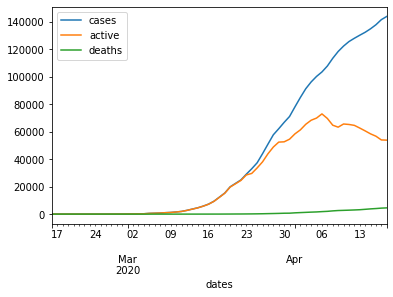

In [61]:
xf = pd.ExcelFile("https://www.python-course.eu/data1/coronacases.xlsx")
df = xf.parse("Sheet1", 
         skiprows=1, 
         index_col=0,
         names=["dates", "cases", "active", "deaths"])

df[["cases", "active", "deaths"]].plot()

The number of cases we here on the media corresponds to the accumulated day by day newly infected people. The number of "active" cases is the number without those who are healed or unfortunately died. The following number shows the ratio of those. As long as nobody had died, the death ratio was 0 %.


In [62]:

discharged = df["cases"] - df["active"]

if "healed" in df.columns:
    df.drop("healed", axis=1, inplace=True)
if "healed" not in df.columns:
    df.insert(loc=len(df.columns),
              column="healed",
              value=(discharged -df["deaths"]))

healed_ratio = df["healed"] * 100 / discharged
healed_ratio




dates
2020-02-16    100.000000
2020-02-17    100.000000
2020-02-18    100.000000
2020-02-19    100.000000
2020-02-20    100.000000
                 ...    
2020-04-14     95.125183
2020-04-15     95.021203
2020-04-16     95.000740
2020-04-17     95.024352
2020-04-18     94.954302
Length: 63, dtype: float64

In [63]:
death_ratio = df["deaths"] * 100 / discharged
death_ratio



dates
2020-02-16    0.000000
2020-02-17    0.000000
2020-02-18    0.000000
2020-02-19    0.000000
2020-02-20    0.000000
                ...   
2020-04-14    4.874817
2020-04-15    4.978797
2020-04-16    4.999260
2020-04-17    4.975648
2020-04-18    5.045698
Length: 63, dtype: float64

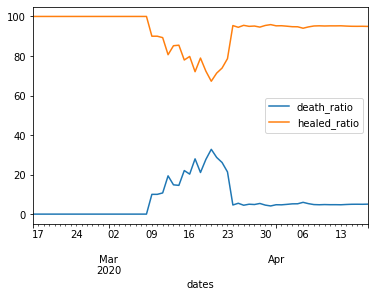

In [64]:
outcome = {"death_ratio": death_ratio, "healed_ratio": healed_ratio}
outcome_df = pd.DataFrame(outcome)
outcome_df
outcome_df.plot()

In [65]:
from sympy import *
init_printing()

x = Symbol("x")
a = Symbol("a")
b = Symbol("b")
c = Symbol("c")

exp(b * x) + c

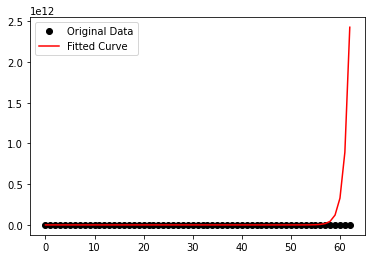

In [66]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def growth_func(x, a, b, c):
  return a * np.exp(b * x) + c
  
Y = df.cases.values
X = np.arange(0, len(Y))
popt, pcov = curve_fit(growth_func, X, Y)
# This probably is equivalent to regression
# But it is non-linear

def growth(x):
    return growth_func(x, *popt)

plt.figure()
plt.plot(X, Y, 'ko', label="Original Data")
plt.plot(X, growth(X), 'r-', label="Fitted Curve")
plt.legend()
plt.show()

In [67]:


days_infected_before_outcome = 14
assumed_real_death_rate = 2.9

def create_inverse_growth_func(a, b, c):
    def inverse(x):
        return np.log((x - c) / a) / b
    return inverse

inverse_growth = create_inverse_growth_func(*popt)

# number of cases 'days_infected_before_outcome':
cases_days_infection_before = df["deaths"][-1] * 100 / assumed_real_death_rate 
shift_days = inverse_growth(cases_days_infection_before)
shift_days -= (len(df) - days_infected_before_outcome)
print(shift_days)



-3.5973978356072394


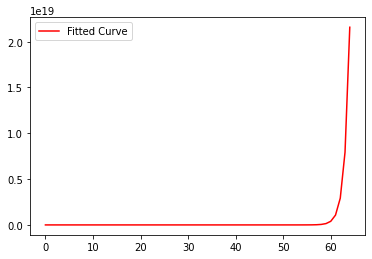

In [68]:
plt.figure()
X = np.arange(0, 65)
plt.plot(X, 
         growth_func(X + days_infected_before_outcome, *popt), 
         'r-', 
         label="Fitted Curve")
plt.legend()
plt.show()

In [69]:
print(len(df["cases"]))
x = np.arange(0, len(df["cases"]))
print(len(x))
if "real" in df.columns:
    df.drop("real", axis=1, inplace=True)
df.insert(loc=len(df.columns),
          column="real",
          value=growth(x+shift_days).astype(np.int))
df

63
63


,cases,active,deaths,healed,real
dates,,,,,
2020-02-16,16,13,0,3,6149
2020-02-17,16,9,0,7,6149
2020-02-18,16,7,0,9,6149
2020-02-19,16,7,0,9,6149
2020-02-20,16,3,0,13,6149
...,...,...,...,...,...
2020-04-14,132210,60515,3495,68200,1218170381
2020-04-15,134753,58349,3804,72600,3311319851
2020-04-16,137698,56646,4052,77000,9001090029


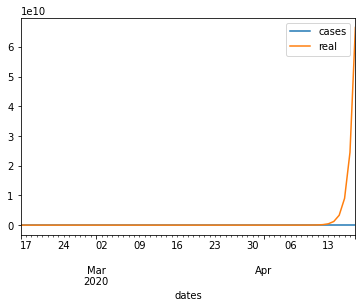

In [70]:


df[["cases", "real"]].plot()

